In [1]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log
51,application_1598227897403_0014,pyspark,idle,Link,Link


SparkSession available as 'spark'.

In [2]:
from pyspark.sql import functions as func

In [3]:
df = spark.read.load("hdfs:///Projects/paysim/paysim_Training_Datasets/PaySim/paysim_month2.parquet") 

In [4]:
df = df.withColumn("label", func.when(func.col("fraud") == "true", 1 ).otherwise(0))

### Rule based system

In [5]:
# Rules to Identify Known Fraud-based
from pyspark.sql import functions as F
df = df.withColumn("rules_label", 
                   F.when(
                     ((df.oldBalanceOrig <= 60000) & (df.action == "TRANSFER") & (df.newBalanceDest <= 90)) |  ((df.oldBalanceOrig > 60000) & (df.newBalanceOrig <= 100)) , 1
                   ).otherwise(0))


In [6]:
df.where((func.col("label")==0) & (func.col("rules_label")==1)).count()

23

In [7]:
df.where((func.col("label")==1) & (func.col("rules_label")==0)).count()

187

In [8]:
df.where((func.col("label")==1) & (func.col("rules_label")==1)).count()

0

In [9]:
df.where((func.col("label")==1)).count()

187

In [10]:
df.where((func.col("label")==0) & (func.col("rules_label")==0)).count()

42059

In [11]:
action_counts = df.select('label','action').groupBy('label','action').agg(func.count('action').alias("value_counts"))
fraud_action_counts = action_counts.where(func.col('label') == 1)
valid_action_counts = action_counts.where(func.col('label') == 0)

In [12]:
%%spark -o fraud_action_counts

In [13]:
%%spark -o valid_action_counts

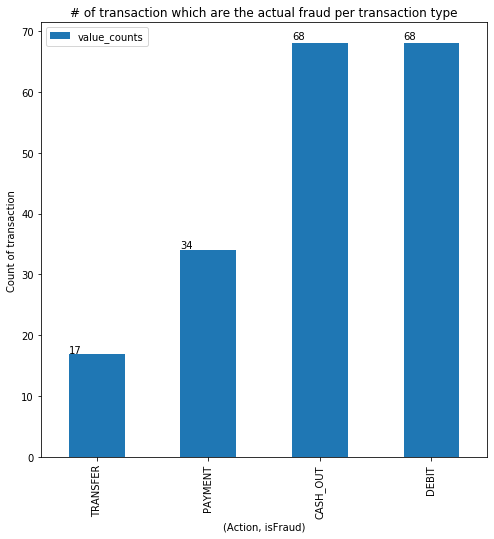

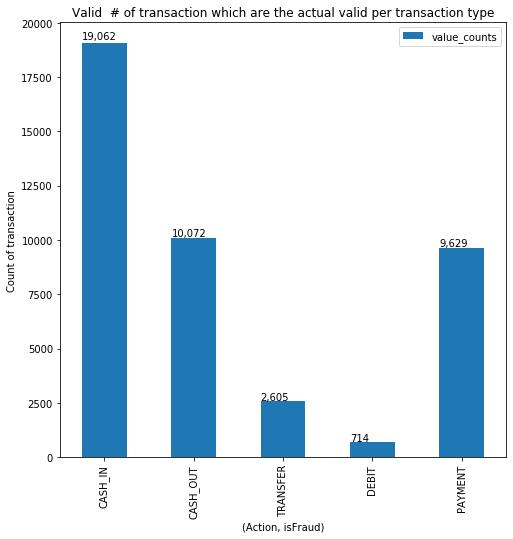

In [14]:
%%local
%matplotlib inline 
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = fraud_action_counts.plot(x='action', y='value_counts' , kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Action, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

plt.show()    

#df.loc[(action_counts.fraud == True), :]
f, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = valid_action_counts.plot(x='action', y='value_counts' , kind='bar', title="Transaction type", ax=ax, figsize=(8,8))
ax.set_title("Valid  # of transaction which are the actual valid per transaction type")
ax.set_xlabel("(Action, isFraud)")
ax.set_ylabel("Count of transaction")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
    
plt.show()    

In [15]:
fraud_transfers = df.where(func.col('action')=='TRANSFER').where(func.col("label")==1)
valid_transfers = df.where(func.col('action')=='TRANSFER').where(func.col("label")==0)

In [16]:
fraud_cash_out = df.where(func.col('action')=='CASH_OUT').where(func.col("label")==1)
valid_cash_out = df.where(func.col('action')=='CASH_OUT').where(func.col("label")==0)

In [17]:
%%spark -o fraud_transfers

In [18]:
%%spark -o valid_transfers

In [19]:
%%spark -o fraud_cash_out

In [20]:
%%spark -o valid_cash_out

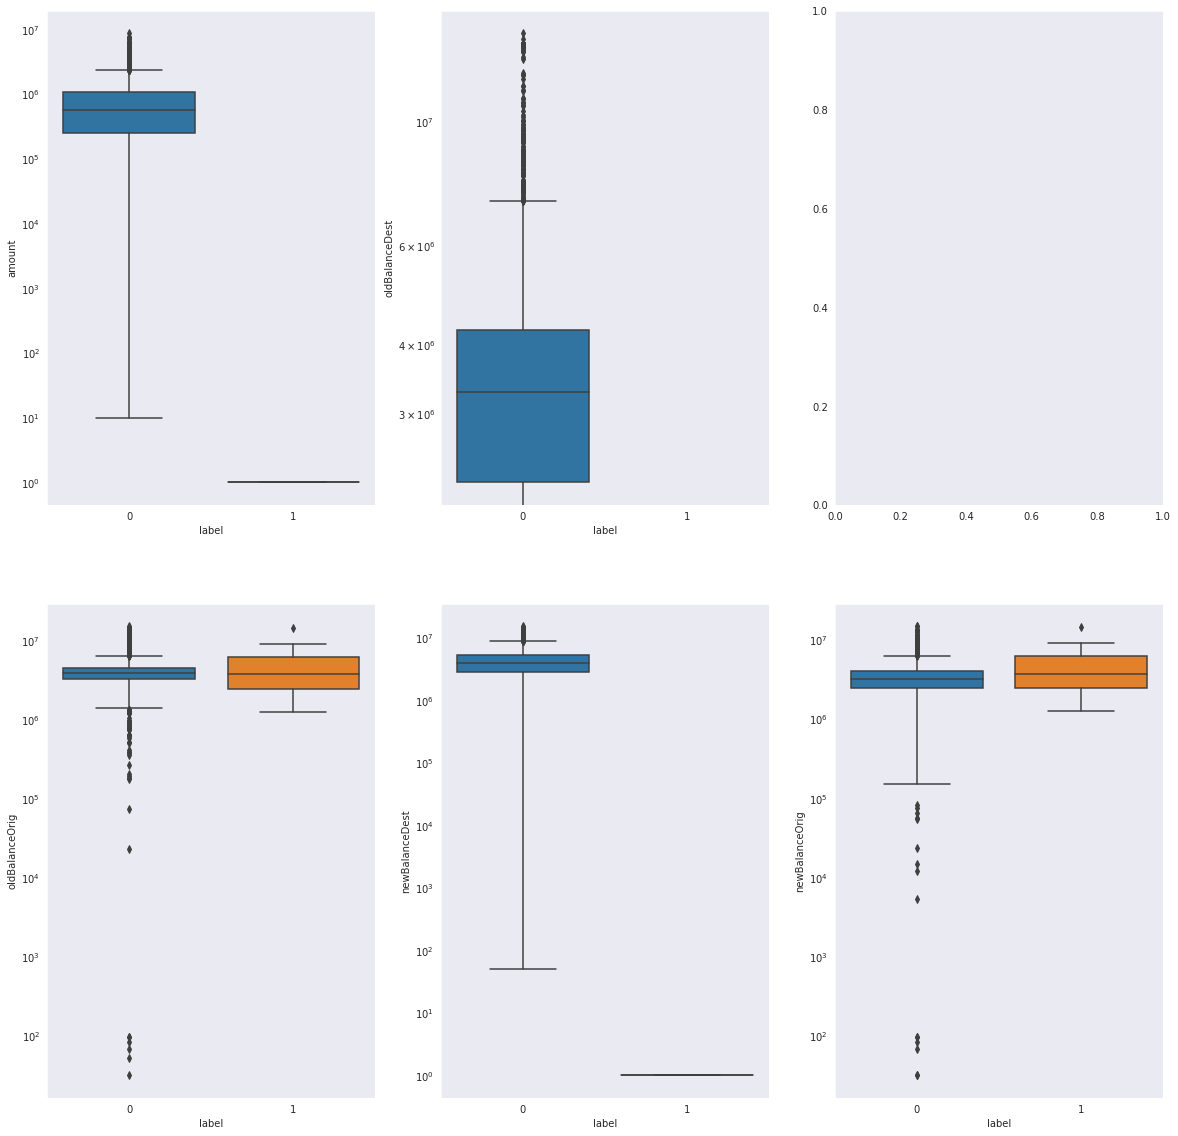

In [21]:
%%local
import seaborn as sns
import pandas as pd
sns.set_style("dark")

transfers = pd.concat([fraud_transfers, valid_transfers])

fig, axs = plt.subplots(2, 3, figsize=(20, 20))
a = sns.boxplot(x = 'label', y = 'amount', data = transfers, ax=axs[0][0])
axs[0][0].set_yscale('log')

b = sns.boxplot(x = 'label', y = 'oldBalanceDest', data = transfers, ax=axs[0][1])
axs[0][1].set_yscale('log')

c = sns.boxplot(x = 'label', y = 'oldBalanceOrig', data=transfers, ax=axs[1][0])
axs[1][0].set_yscale('log')

d = sns.boxplot(x = 'label', y = 'newBalanceDest', data = transfers, ax=axs[1][1])
axs[1][1].set_yscale('log')

f = sns.boxplot(x = 'label', y = 'newBalanceOrig', data=transfers, ax=axs[1][2])
axs[1][2].set_yscale('log')
plt.show()

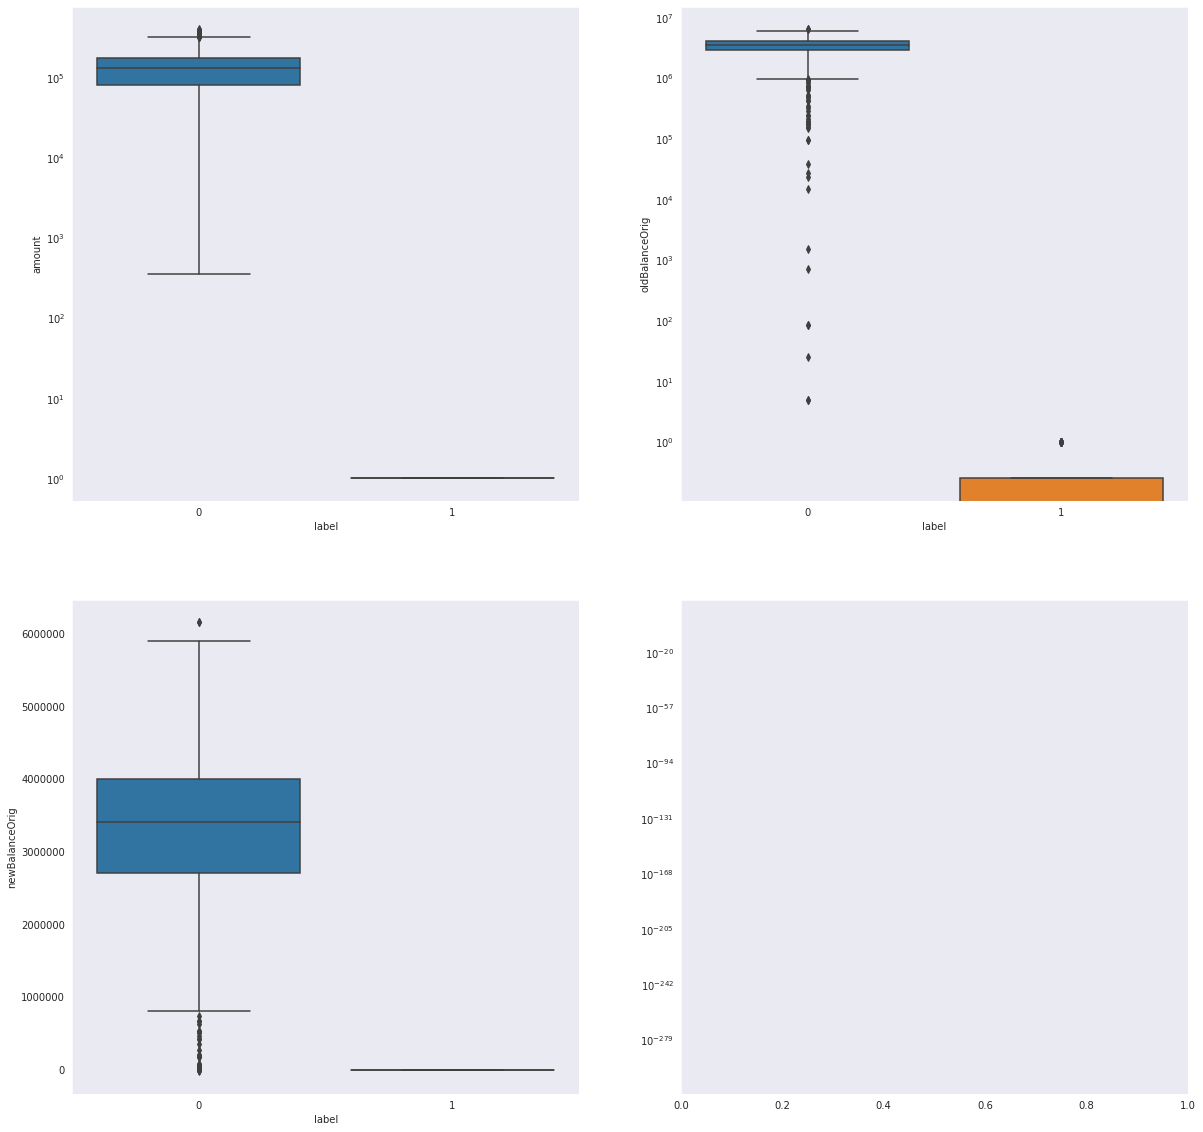

In [22]:
%%local

cash_out = pd.concat([fraud_cash_out, valid_cash_out])

fig, axs = plt.subplots(2, 2, figsize=(20, 20))
a = sns.boxplot(x = 'label', y = 'amount', data=cash_out, ax=axs[0][0])
axs[0][0].set_yscale('log')

b = sns.boxplot(x = 'label', y = 'oldBalanceOrig', data=cash_out, ax=axs[0][1])
axs[0][1].set_yscale('log')

c = sns.boxplot(x = 'label', y = 'newBalanceOrig', data=cash_out, ax=axs[1][0])
axs[1][1].set_yscale('log')#.set(ylim=(0, 3e7))
plt.show()